## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from sklearn.pipeline import Pipeline   
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,    
    mean_absolute_percentage_error,
    r2_score,
) # for regression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
) # for classification

## Data preprocessing 

### Read data and rename column

In [2]:
df = pd.read_csv('players_transformed.csv')
df = df.drop(df.columns[0], axis=1)
# Define a dictionary mapping old column names to new ones
column_renaming = {
    'name': 'Name',
    'age': 'Age',
    'nationality': 'Nationality',
    'club': 'Club',
    'height': 'Height',
    'weight': 'Weight',
    'foot': 'Foot',
    'total_matches': 'Total Matches',
    'total_goals': 'Total Goals',
    'total_assists': 'Total Assists',
    'total_goals_conceded': 'Total Goals Conceded',
    'total_cs': 'Total CS',
    'total_yellow': 'Total Yellow Cards',
    'total_red': 'Total Red Cards',
    'shot_accuracy': 'Shot Accuracy',
    'pass_completion_rate': 'Pass Completion Rate',
    'cross_completion_rate': 'Cross Completion Rate',
    'dribble_success_rate': 'Dribble Success Rate',
    'tackles': 'Tackles',
    'interception': 'Interceptions',
    'market_value': 'Market Value',
    'titles': 'Titles',
    'injuries': 'Injuries',
    'general_position': 'General Position'
}
df.rename(columns=column_renaming, inplace=True)

percent_columns = [
    'Shot Accuracy',
    'Pass Completion Rate',
    'Cross Completion Rate',
    'Dribble Success Rate'
]

df[percent_columns] = df[percent_columns] / 100
df.describe()

,Age,Height,Weight,Total Matches,Total Goals,Total Assists,Total Goals Conceded,Total CS,Total Yellow Cards,Total Red Cards,Shot Accuracy,Pass Completion Rate,Cross Completion Rate,Dribble Success Rate,Tackles,Interceptions,Market Value,Titles,Injuries
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,25.623853,182.607951,74.815291,213.913761,20.151070,15.701529,229.708869,69.060550,32.273394,1.553517,0.432652,0.804504,0.224825,0.389460,8.098471,4.044037,9.279128,2.018960,7.647706
std,4.087901,6.254873,6.193840,125.230370,22.080936,11.773836,92.234625,28.243293,26.910919,1.880140,0.257537,0.100259,0.182816,0.306014,7.421608,4.292177,9.205184,3.266275,8.717064
min,16.000000,162.000000,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000
25%,23.000000,179.000000,72.000000,117.000000,4.000000,7.000000,166.000000,50.000000,12.000000,0.000000,0.333300,0.767950,0.153800,0.000000,2.000000,1.000000,2.500000,0.000000,1.000000
50%,26.000000,183.000000,75.000000,204.000000,12.000000,14.000000,227.000000,68.000000,26.000000,1.000000,0.461500,0.819800,0.214300,0.428600,6.000000,3.000000,6.000000,1.000000,5.000000
75%,28.000000,187.000000,78.000000,307.000000,29.000000,23.000000,291.000000,86.000000,47.000000,2.000000,0.500000,0.864450,0.258700,0.545500,12.000000,6.000000,12.000000,3.000000,11.000000
max,44.000000,206.000000,98.000000,589.000000,100.000000,69.000000,546.000000,175.000000,161.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39.000000,24.000000,40.000000,35.000000,79.000000


### Other functions to visualize data

In [3]:
def plot_all_numerical_columns(df, col):
    """
    Plots all numerical columns in the dataframe against a specified column on the y-axis,
    with 3 plots per row.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - col (str): The name of the column to be used as the y-axis.
    """
    # Filter numerical columns in the dataframe
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove the y-axis column from the numerical columns
    if col in numerical_columns:
        numerical_columns.remove(col)
    
    # Set up the figure size and grid layout (3 plots per row)
    num_plots = len(numerical_columns)
    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed
    plt.figure(figsize=(15, num_rows * 5))
    
    # Loop through each numerical column and create a scatter plot
    for idx, col_x in enumerate(numerical_columns, 1):
        plt.subplot(num_rows, 3, idx)  # Adjust the grid to fit 3 plots per row
        sns.scatterplot(data=df, x=col_x, y=col, alpha=0.7)
        plt.title(f'Relationship between {col_x} and {col}')
        plt.xlabel(col_x)
        plt.ylabel(col)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix_all_cols(df):
    # Compute the correlation matrix
    df_numeric = df.select_dtypes('number')
    correlation_matrix = df_numeric.corr()

    # Set up the figure size
    plt.figure(figsize=(12, 8))

    # Create the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)

    # Adding title and labels
    plt.title('Correlation Matrix')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### First we view the correlation matrix to look for columns that are too highly correlated

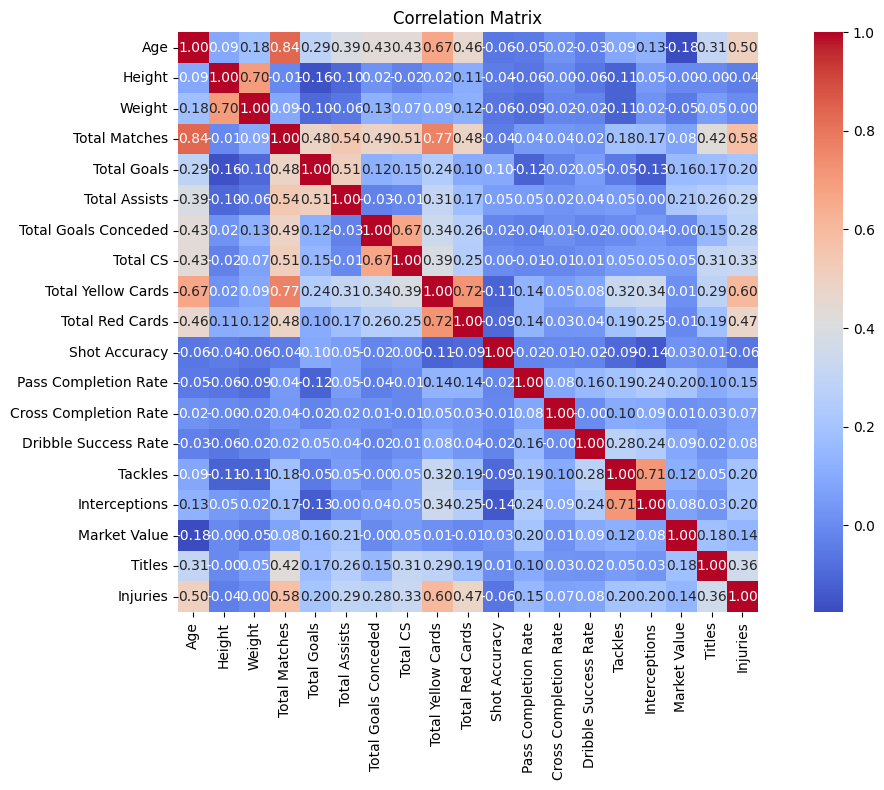

In [4]:
plot_correlation_matrix_all_cols(df)

- Total Matches, Ages are too highly correlated with each other with 0.84. So I will drop total matches.

In [5]:
df = df.drop(columns=['Total Matches'])
print(df.shape)
df_copy = df.copy()

(1635, 23)


### Group features to reduce dimension of data for better modelling

In [6]:
ball_skills = ['Dribble Success Rate', 'Shot Accuracy']
defense_skills = ['Tackles','Interceptions']
attack_skills = ['Pass Completion Rate','Cross Completion Rate']
career_stats = ['Total CS','Total Assists', 'Total Goals']
df_regression = df.copy()         
df_regression['Ball Skill'] = (df_regression[ball_skills].sum(axis=1)) / len(ball_skills)
df_regression['Defense Skill'] = df_regression[defense_skills].sum(axis=1) / len(defense_skills)
df_regression['Attack Skill'] = df_regression[attack_skills].sum(axis=1) / len(attack_skills) 
df_regression['Discipline Score'] = (df_regression['Total Red Cards']*2 + df_regression['Total Yellow Cards'])/2
df_regression['Career Stats'] = df_regression[career_stats].sum(axis=1) / len(career_stats)

df_regression = df_regression.drop(columns=(ball_skills + defense_skills + attack_skills + career_stats))
df_regression = df_regression.drop(columns='Total Yellow Cards')
df_regression = df_regression.drop(columns='Total Red Cards')

df_regression.describe()

,Age,Height,Weight,Total Goals Conceded,Market Value,Titles,Injuries,Ball Skill,Defense Skill,Attack Skill,Discipline Score,Career Stats
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,25.623853,182.607951,74.815291,229.708869,9.279128,2.018960,7.647706,0.411056,6.071254,0.514665,17.690214,34.971050
std,4.087901,6.254873,6.193840,92.234625,9.205184,3.266275,8.717064,0.197951,5.454353,0.107823,14.871653,14.412484
min,16.000000,162.000000,50.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333
25%,23.000000,179.000000,72.000000,166.000000,2.500000,0.000000,1.000000,0.230750,1.500000,0.449400,6.500000,24.333333
50%,26.000000,183.000000,75.000000,227.000000,6.000000,1.000000,5.000000,0.445050,4.500000,0.517050,14.000000,33.666667
75%,28.000000,187.000000,78.000000,291.000000,12.000000,3.000000,11.000000,0.507000,9.000000,0.557175,25.500000,44.166667
max,44.000000,206.000000,98.000000,546.000000,40.000000,35.000000,79.000000,1.000000,27.000000,1.000000,92.500000,82.000000


### Encode the categorical data

In [7]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded = one_hot_encoder.fit_transform(df[['Club']])
encoded_df = pd.DataFrame(encoded, 
                          columns=one_hot_encoder.get_feature_names_out(['Club']), 
                          index=df_regression.index)
df_regression = pd.concat([df_regression, encoded_df], axis=1)
df_regression.describe()

,Age,Height,Weight,Total Goals Conceded,Market Value,Titles,Injuries,Ball Skill,Defense Skill,Attack Skill,...,Club_Union Berlin,Club_Valencia CF,Club_Venezia,Club_Villarreal,Club_Watford,Club_Werder Bremen,Club_West Bromwich Albion,Club_West Ham United,Club_Wolfsburg,Club_Wolverhampton Wanderers
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,...,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,25.623853,182.607951,74.815291,229.708869,9.279128,2.018960,7.647706,0.411056,6.071254,0.514665,...,0.009174,0.013456,0.012232,0.009786,0.000612,0.009174,0.000612,0.009174,0.011009,0.009174
std,4.087901,6.254873,6.193840,92.234625,9.205184,3.266275,8.717064,0.197951,5.454353,0.107823,...,0.095371,0.115251,0.109955,0.098469,0.024731,0.095371,0.024731,0.095371,0.104377,0.095371
min,16.000000,162.000000,50.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,179.000000,72.000000,166.000000,2.500000,0.000000,1.000000,0.230750,1.500000,0.449400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,183.000000,75.000000,227.000000,6.000000,1.000000,5.000000,0.445050,4.500000,0.517050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,28.000000,187.000000,78.000000,291.000000,12.000000,3.000000,11.000000,0.507000,9.000000,0.557175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,44.000000,206.000000,98.000000,546.000000,40.000000,35.000000,79.000000,1.000000,27.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalize skewed columns

In [8]:
df_classification = df.copy()
right_skewed_columns = [col for col in df_classification.select_dtypes('number').columns if (df_classification[col].skew()  > 1 and col != 'Market Value')]
left_skewed_columns = [col for col in df_classification.select_dtypes('number').columns if (df_classification[col].skew()  < -1 and col != 'Market Value')]
for col in right_skewed_columns:
    df_classification[f'log_{col}'] = np.log1p(df_classification[col])  # Use log(1 + x) to handle zeros
for col in left_skewed_columns:
    df_classification[f'log_reversed_{col}'] = np.log1p(df_classification[col].max() + 1 - df_classification[col])  # Reverse and log transform

# Drop the original columns
df_classification = df_classification.drop(columns=right_skewed_columns + left_skewed_columns)
print(df_classification.shape)
display(df_classification.head())

(1635, 23)


,Name,Age,Nationality,Club,Height,Weight,Foot,Total Goals Conceded,Total CS,Shot Accuracy,...,log_Total Goals,log_Total Assists,log_Total Yellow Cards,log_Total Red Cards,log_Cross Completion Rate,log_Tackles,log_Interceptions,log_Titles,log_Injuries,log_reversed_Pass Completion Rate
0,Ardian Ismajli,28,Albania,Empoli,185,76,Right,251.0,70.0,0.0000,...,1.791759,2.890372,4.025352,1.098612,0.194168,2.302585,3.091042,0.000000,1.386294,0.770664
1,Berat Djimsiti,31,Albania,Atalanta,190,83,Right,531.0,133.0,0.0000,...,2.772589,2.302585,4.382027,0.693147,0.000000,3.295837,2.995732,1.098612,1.791759,0.751416
2,Ivan Balliu,32,Albania,Rayo Vallecano,172,63,Right,473.0,120.0,0.4615,...,1.386294,2.302585,4.521789,1.098612,0.000000,2.397895,1.945910,1.098612,2.995732,0.803212
3,Kristjan Asllani,22,Albania,Inter Milan,175,63,Right,329.0,44.0,0.5000,...,1.945910,1.791759,2.302585,0.000000,0.405465,1.609438,0.000000,1.945910,0.693147,0.739219
4,Marash Kumbulla,24,Albania,RCD Espanyol,191,78,Right,121.0,42.0,0.5000,...,1.945910,1.945910,3.496508,1.098612,0.510846,2.564949,2.484907,0.693147,1.386294,0.760806


## Split the data into train set and test set

In [9]:
X = df_regression.drop(['Market Value', 'Name', 'Nationality', 'Club', 'Foot','General Position'], axis=1)  
X.info()
y_market_value = df_regression['Market Value']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Columns: 177 entries, Age to Club_Wolverhampton Wanderers
dtypes: float64(172), int64(5)
memory usage: 2.2 MB


# MODELLING

## Declare class for regression model
The `RegressionModelEvaluator` class is designed to simplify the process of evaluating and comparing multiple regression models on a given dataset. It integrates data preprocessing, model training, metric calculation and result visualization into a seamless workflow.
<hr>

### 1. Class Overview
**Purpose**: 
- To evaluate and compare the perfomrmance of various regression models on the same dataset.
- To provide a systematic approach to analyzing model predictions and regression metrics.

**Key Features**: 
- Automatic Data Splitting: Split the dataset into training and testing sets.
- Preprocessing with Pipeline: Standardize input features and integrates models using `scikit-learn` pipelines.
- Extensice Metric Support: Calculate multiple regression metrics for comprehensive evaluation.
- Visualization: Produces scatter plots of actual vs. predicted values to visually assess model accuracy.
- Scalability: Easily extendable to include additional models, metrics, or preprocessing steps.
<hr>

### 2. Class Constructor
`__init__(self, X, y, models, test_size=0.2, random_state=42)`
**Parameters**:
- `X`: Feature matrix
  - Type: `pandas.DataFrame`
  - Shape: `(n_samples, n_features)` where `n_samples` is the number of samples and `n_features` is the number of features.
- `y`: Target vector
  - Type: `pandas.Series`
  - Shape: `(n_samples,)`
- `models`: Dictionary of regression models
  - Keys: Model names (string)
  - Values: Instantiated regression models objects (e.g., `LinearRegression()`, `RandomForestRegressor()`)
- `test_size`: Proportion of the dataset to allocate for testing
  - Type: `float`
  - Default: `0.2`
- `random_state`: Seed for random number generator
  - Type: `int`
  - Default: `42`
**Instance Variables**:
- `self.X_train`: Training features set.
- `self.X_test`: Testing features set.
- `self.y_train`: Training target set.
- `self.y_test`: Testing target set.  
- `self.models`: Dictionary of regression models.
- `self.results`: Dictionary of regression metrics.
**Functionality**:
The constructor automatically splits the dataset into training and test subsets using `tran_test_split()` from `scikit-learn`. It also initializes the `results` dictionary to store regression metrics for each model.
<hr>

### 3. Methods
#### 3.1 `evaluate_models(self)`
**Description**
This method trains each model on the traning set, make predictions on the test set, and computes evaluation metrics.

**Steps:**
1. Preprocessing: A `Pipeline` is created for each model with:
- `StandardScaler`: Standardizes the features to have zero mean and unit variance.
- The regression model provided in the `models` dictionary.
2. Training: The pipeline is fitted to the traning data.
3. Prediction: Predictions are made on the test set.
4. Metric Calculation: The following metrics are computed:
- Mean Squared Error (MSE): Average squared difference between actual and predicted values.
- Root Mean Squared Error (RMSE): Square root of the MSE, representing errors in the same scale as the target.
- Mean Absolute Error (MAE): Average absolute difference between actual and predicted values.
- Mean Absolute Percentage Error (MAPE): Average percentage difference between actual and predicted values.
- R-Squared (R2): Proportion of variance in the target variable explained by the model.
5. Results Storage: Metrics are stored in the `results` dictionary.

**Returns**
- A dictionary containing:
    - Metrics for each model.
    - Predictions for the test set.

#### 3.2 `visualize_results(self)` 
**Description**
Generates scatter plots comparing actual and predicted values for each model. 

**Steps:**
1. Setup: Initializes a multi-panel Matplotlib figure.
2. Plotting: For each model:
   - Creates a scatter plot of actual values (`y-test`) vs. predicted values.
   - Adds a red dashed diagonal line representing perfect predictions.
3. Layout: Adjusts layout for readability

**Output**
- Visualizations showing the alignment between actual and predicted values for each model.

**Purpose**
- To visually assess model accuracy.
- To identify potential patterns or biases in the predictions

#### 3.3 `print_detailed_metrics(self)`
**Description**
Prints detailed evaluation metrics for each model in a clear and formatted manner.

**Output**
For each model, the following metrics are displayed:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- R-Squared (R2)


## Topic
We train the model to predict the market value of a player based on the features provided in the dataset. We will use the following regression models:
- Decision Tree Regressor 
- Random Forest Regressor
- Neural Network Regressor

In [10]:
class RegressionModelEvaluator:
    def __init__(self, X, y, models, test_size=0.2, random_state=42):
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Store models
        self.models = models

        # Initialize results dictionary
        self.results = {}

    def evaluate_models(self):
        for name, model in self.models.items():
            # Create a pipeline for each model
            model_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])

            # Fit the model
            model_pipeline.fit(self.X_train, self.y_train)

            # Make predictions
            y_pred = model_pipeline.predict(self.X_test)

            # Calculate metrics
            metrics = {
                'MSE': mean_squared_error(self.y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_test, y_pred)),
                'MAE': mean_absolute_error(self.y_test, y_pred),
                'MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'R2': r2_score(self.y_test, y_pred)
            }

            # Store the metrics in the results dictionary
            self.results[name] = {
                'metrics': metrics,
                'predictions': y_pred
            }

        return self.results
    
    def visualize_predictions(self):
        """
        Create comprehensive visualizations of model predictions
        """
        plt.figure(figsize=(15, 5 * len(self.results)))
        
        for idx, (model_name, result) in enumerate(self.results.items(), 1):
            # Actual vs Predicted Plot
            plt.subplot(len(self.results), 2, 2*idx-1)
            plt.scatter(self.y_test, result['predictions'], alpha=0.7)
            plt.plot([self.y_test.min(), self.y_test.max()], 
                     [self.y_test.min(), self.y_test.max()], 
                     'r--', lw=2)
            plt.title(f'{model_name}: Actual vs Predicted')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')

        plt.tight_layout()
        plt.show()

    def print_detailed_metrics(self):
        """
        Print detailed metrics for each model
        """
        print("Detailed Model Performance Metrics:\n")
        for name, result in self.results.items():
            print(f"{name}:")
            for metric, value in result['metrics'].items():
                print(f"  {metric}: {value:.4f}")
            print()

## Evaluate Decision Tree/Random Forest/Nerual Network models

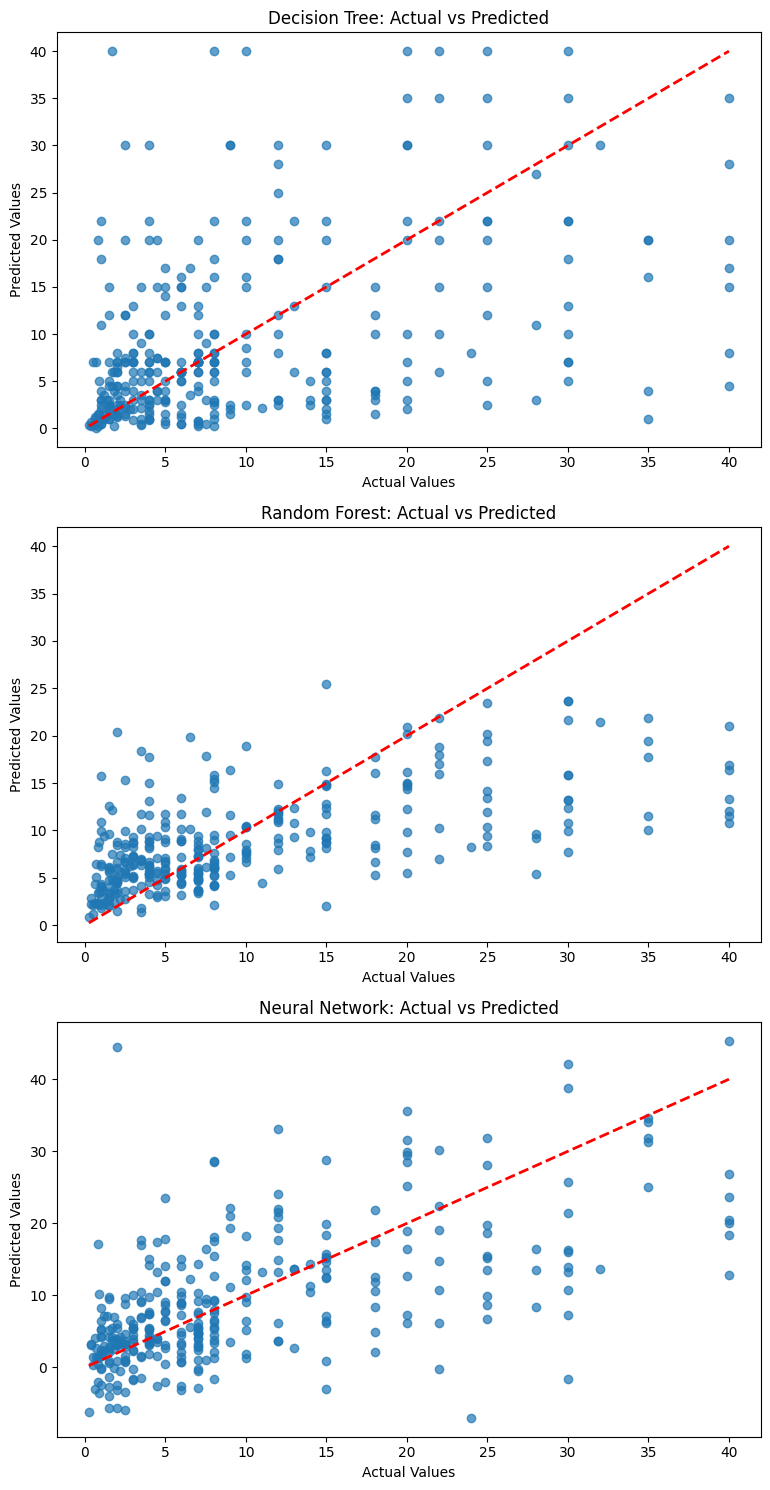

Detailed Model Performance Metrics:

Decision Tree:
  MSE: 98.7437
  RMSE: 9.9370
  MAE: 6.7194
  MAPE: 1.2623
  R2: -0.0892

Random Forest:
  MSE: 58.5515
  RMSE: 7.6519
  MAE: 5.1822
  MAPE: 1.1484
  R2: 0.3541

Neural Network:
  MSE: 68.8405
  RMSE: 8.2970
  MAE: 5.8281
  MAPE: 1.2550
  R2: 0.2407



In [11]:
# Define models to evaluate
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
}

# Initialize the evaluator
evaluator = RegressionModelEvaluator(X, y_market_value, models)

# Evaluate the models
results = evaluator.evaluate_models()
regresession_result = results

# Visualize the predictions
evaluator.visualize_predictions()

# Print detailed metrics
evaluator.print_detailed_metrics()

## Declare class for classification model

Similar to `RegressionModelEvaluator`, The `ClassificationModelEvaluator` class is designed to evaluate multiple classification models on a given dataset.

### Purpose

- Simplify the process of training and evaluating classification models by automating common tasks.
- Provide comprehensive metrics and visualizations for model comparison and performance assessment.
- Handle preprocessing steps, such as scaling, within a pipeline, ensuring data consistency and compatibility with various models.

### Key features

- Data Splitting: Automatically splits the dataset into training and test sets, with stratification for balanced class representation.
- Pipeline Integration: Includes a pipeline that applies preprocessing (e.g., scaling) before training each model.
- Metrics Calculation: Computes common classification metrics, such as accuracy, precision, recall, and F1-score.
- Visualization: Creates confusion matrix plots for visual performance analysis.
- Detailed Reports: Provides a detailed breakdown of each model's performance, including a classification report.

### Constructor

The `__init__` method initializes the class by:
- Splitting the dataset into training and test sets using `train_test_split` with stratification for balanced classes.
- Accepting a list of models to evaluate and storing them.
- Initializing an empty dictionary (`self.results`) to store the results for each model.

Key Arguments:
- `X` (features) and `y` (labels): Input data for the evaluation.
- `models`: A dictionary where keys are model names, and values are scikit-learn classifier instances.
- `test_size`: Proportion of the data to reserve for testing (default: 20%).
- `random_state`: Ensures reproducibility.

### Methods

#### 1. `evaluate_models` Method

Trains and evaluates each model in the models dictionary.

**Steps**:

- **Pipeline Creation**: Creates a pipeline with:
    - Scaler: `MinMaxScaler` to normalize feature values to the range [0, 1].
    - Classifier: The provided model.
- **Model Training**: Fits the pipeline on the training data (`self.X_train`, `self.y_train`).
-  **Prediction**: Generates predictions (`y_pred`) and class probabilities (`y_proba`) if supported by the model.
-  **Metrics Calculation**: Computes:
    - Accuracy: Percentage of correctly predicted labels.
    - Precision: Ratio of true positives to all positive predictions (weighted average for multiclass).
    - Recall: Ratio of true positives to all actual positives (weighted average for multiclass).
    - F1-Score: Harmonic mean of precision and recall (weighted average for multiclass).
- **Result Storage**: Stores metrics, predictions, and probabilities (if available) in `self.results`.

#### 2. `visualize_confusion_matrices` Method

Generates confusion matrices for all models and displays them using heatmaps.

**Steps**:

- Iterates through `self.results` to access predictions for each model.
- Computes the confusion matrix using `confusion_matrix(self.y_test, result['predictions'])`.
- Visualizes the matrix using seaborn's heatmap:
    - Annotates with numerical values.
    - Labels axes with the unique class labels.
- Displays all matrices in a grid layout for easy comparison.

#### 3. `print_detailed_metrics` Method

Prints a comprehensive report of metrics and classification results for each model.

**Steps**:

- Iterates through self.results to access metrics and predictions.
- For each model:
    - Prints computed metrics (accuracy, precision, recall, F1-score).
    - Generates a detailed classification report using `classification_report` from scikit-learn, including:
        - Per-class precision, recall, F1-score, and support (number of samples in each class).
- Formats the output for readability.

### Python class definition

In [12]:
class ClassificationModelEvaluator:
    def __init__(self, X, y, models, test_size=0.2, random_state=42):
        # Split the dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Store the models
        self.models = models
        
        # Dictionary to store results
        self.results = {}

    def evaluate_models(self):
        for name, model in self.models.items():
            # Create a pipeline for each model
            model_pipeline = Pipeline([
                ('scaler', MinMaxScaler()),
                ('classifier', model)
            ])
            
            # Fit the model
            model_pipeline.fit(self.X_train, self.y_train)
            
            # Make predictions
            y_pred = model_pipeline.predict(self.X_test)
            y_proba = model_pipeline.predict_proba(self.X_test)[:, 1] if hasattr(model, "predict_proba") else None
            
            # Compute metrics
            metrics = {
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted'),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1-Score': f1_score(self.y_test, y_pred, average='weighted'),
            }
            
            # Store metrics and predictions
            self.results[name] = {
                'metrics': metrics,
                'predictions': y_pred,
                'probabilities': y_proba
            }
        
        return self.results
    
    def visualize_confusion_matrices(self):
        """
        Create confusion matrix visualizations for all models.
        """
        plt.figure(figsize=(15, 5 * len(self.results)))
        
        for idx, (model_name, result) in enumerate(self.results.items(), 1):
            cm = confusion_matrix(self.y_test, result['predictions'])
            plt.subplot(len(self.results), 1, idx)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
            plt.title(f'{model_name}: Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
        
        plt.tight_layout()
        plt.show()

    def print_detailed_metrics(self):
        """
        Print detailed metrics for each model.
        """
        print("Detailed Model Performance Metrics:\n")
        for name, result in self.results.items():
            print(f"{name}:")
            for metric, value in result['metrics'].items():
                if value is not None:
                    print(f"  {metric}: {value:.4f}")
            print()
            print("Classification Report:")
            print(classification_report(self.y_test, result['predictions'], digits=4))
            print()

## Evaluate target classification models

The models chosen for evaluation are as follow

### 1. Decision Tree Classification

A Decision Tree Classifier is a supervised learning algorithm that splits the data into subsets based on feature values, forming a tree-like structure. Each internal node represents a decision based on a feature, each branch corresponds to the outcome of the decision, and each leaf node represents a class label. Decision trees are interpretable, handle both numerical and categorical data, and work well with non-linear relationships, but they can be prone to overfitting without proper pruning or constraints. ([source:geeksforgeeks.com](https://www.geeksforgeeks.org/decision-tree/))

### 2. Naive Bayes Classification

The Naive Bayes Classifier is a probabilistic algorithm based on Bayes' Theorem, assuming that features are conditionally independent given the class label (the "naive" assumption). It calculates the probability of each class for a given input and predicts the one with the highest likelihood. This model is computationally efficient and performs well on high-dimensional and text-based data, though its strong independence assumption can limit its accuracy in some real-world scenarios. ([source:javatpoint.com](https://www.javatpoint.com/machine-learning-naive-bayes-classifier))

### 3. K-Nearest Neighbors (KNN) Classification

The K-Nearest Neighbors Classifier is a non-parametric, instance-based algorithm that classifies a data point based on the majority class of its $k$-nearest neighbors in the feature space. Distances, such as Euclidean or Manhattan, are used to determine closeness. KNN is simple and effective for small datasets, but it can be computationally expensive and sensitive to irrelevant features or unbalanced data distributions. ([source:w3schools.com](https://www.w3schools.com/python/python_ml_knn.asp))

### Split data for classification

In [13]:
X = df_classification.drop(['Name', 'Nationality', 'Club', 'Foot', 'General Position'], axis=1)  # Replace 'target_column' with your actual target column name  
y_position = df_classification['General Position']

## Evaluation using Decision Tree/Naive Bayes/ K-nearest neighbors

c:\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

Detailed Model Performance Metrics:

Decision Tree:
  Accuracy: 0.7187
  Precision: 0.7229
  Recall: 0.7187
  F1-Score: 0.7201

Classification Report:
              precision    recall  f1-score   support

    Defender     0.8058    0.7411    0.7721       112
     Forward     0.6923    0.7200    0.7059        75
  Goalkeeper     0.9091    0.9091    0.9091        22
  Midfielder     0.6290    0.6610    0.6446       118

    accuracy                         0.7187       327
   macro avg     0.7591    0.7578    0.7579       327
weighted avg     0.7229    0.7187    0.7201       327


Naive Bayes:
  Accuracy: 0.4893
  Precision: 0.4317
  Recall: 0.4893
  F1-Score: 0.4255

Classification Report:
              precision    recall  f1-score   support

    Defender     0.6222    0.5000    0.5545       112
     Forward     0.0000    0.0000    0.0000        75
  Goalkeeper     1.0000    0.3636    0.5333        22
  Midfielder     0.4192    0.8136    0.5533       118

    accuracy                 

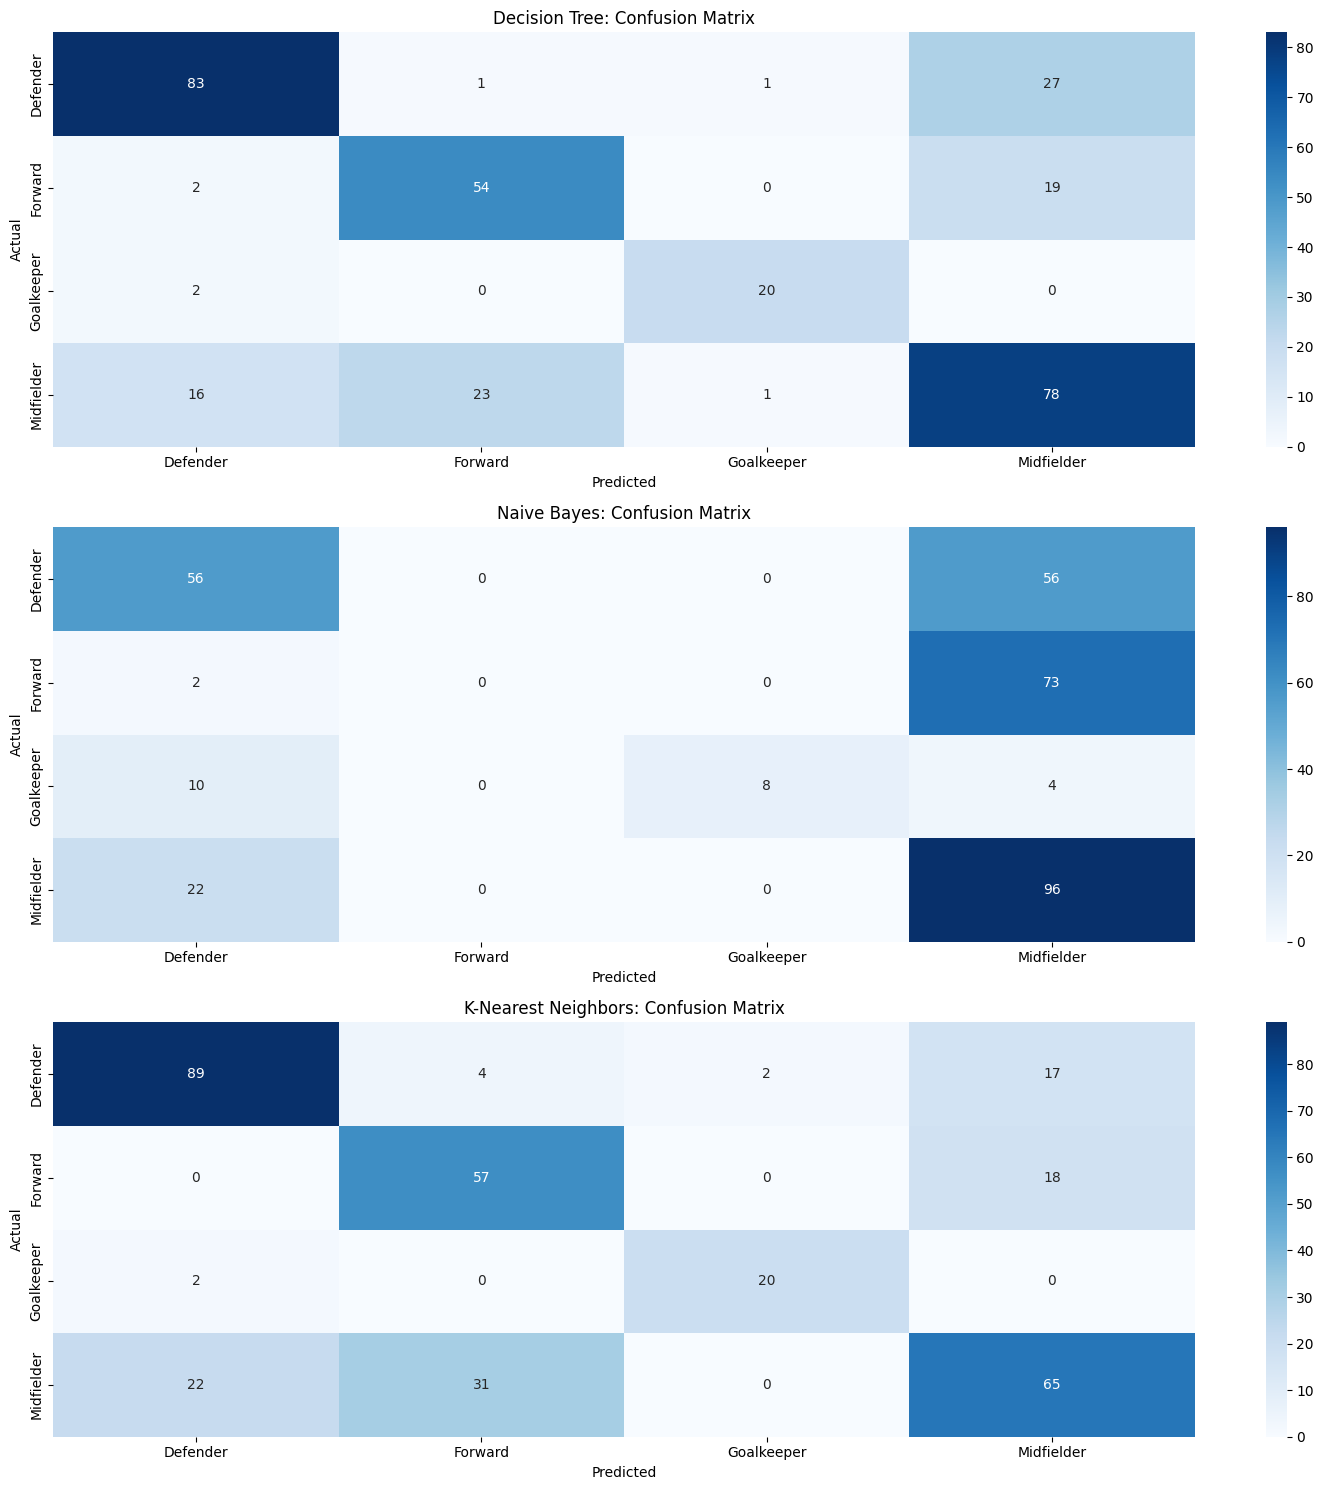

In [14]:
# Create the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# create Naive Bayes model
naive_bayes = MultinomialNB()

# Define parameter grid
param_grid = {'n_neighbors': range(1, 20)}

# Perform grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y_position)

# Best number of neighbors
n_best = grid_search.best_params_['n_neighbors']

# Define the KNN model
knn_model = KNeighborsClassifier(n_neighbors=n_best)

# Define the model dictionary
models = {
    'Decision Tree': decision_tree,
    'Naive Bayes': naive_bayes,
    'K-Nearest Neighbors': knn_model
}

# Create the evaluator
evaluator = ClassificationModelEvaluator(X, y_position, models)

# Evaluate models
results = evaluator.evaluate_models()
classification_result = results

# Print detailed metrics
evaluator.print_detailed_metrics()

# Visualize confusion matrix
evaluator.visualize_confusion_matrices()

## Choose the best model
### Regression Criterias:
1. Minimise MSE
2. Maximise R^2
### Classification Criterias:
1. Maximise F1
2. Maximise Accuracy

In [15]:
regression_metrics, classification_metrics = [], []
for model in regresession_result.items():
    metrics = model[1]['metrics']
    regression_metrics.append(metrics)
    # display(metrics)
for model in classification_result.items():
    metrics = model[1]['metrics']
    classification_metrics.append(metrics) 
    # display(metrics)   
# Find best regression model index 
best_regression_index = min(range(len(regression_metrics)), key=lambda i: (regression_metrics[i]['MSE'], -regression_metrics[i]['R2']))

# Find best classification model index
best_classification_index = max(range(len(classification_metrics)), key=lambda i: (classification_metrics[i]['F1-Score'], classification_metrics[i]['Accuracy']))

regression_keys = list(regresession_result.keys())
classification_keys = list(classification_result.keys())


print("The best regression model is:",regression_keys[best_regression_index])
display(regresession_result[regression_keys[best_regression_index]]['metrics'])
print("The best classifcation model is",classification_keys[best_classification_index])
display(classification_result[classification_keys[best_classification_index]]['metrics'])

The best regression model is: Random Forest


{'MSE': 58.5515038398318,
 'RMSE': 7.651895440989232,
 'MAE': 5.182155963302752,
 'MAPE': 1.1484416692491564,
 'R2': 0.35414712013594973}

The best classifcation model is Decision Tree


{'Accuracy': 0.7186544342507645,
 'Precision': 0.7229397876426784,
 'Recall': 0.7186544342507645,
 'F1-Score': 0.7201275558951643}

# Differences of models

## Comparison of Decision Tree, Random Forest, and Neural Network Models

### Advantages and Disadvantages Comparison

| **Model**           | **Advantages**                                                                                  | **Disadvantages**                                                                               | **Best Suited For**                                                       |
|----------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Decision Tree**    | - Easy to interpret and visualize.<br>- Handles both categorical and numerical data.<br>- No scaling or normalization required.<br>- Handles missing values.<br>- Fast for small datasets. | - Prone to overfitting without pruning.<br>- Unstable (small changes in data can lead to a different tree).<br>- Biased towards features with more levels. | - Simple, interpretable problems.<br>- Situations requiring clear decision paths. |
| **Random Forest**    | - Reduces overfitting compared to a single Decision Tree.<br>- Handles large datasets well.<br>- Works well with missing or imbalanced data.<br>- Measures feature importance.<br>- Robust to noise and outliers. | - Slower and more computationally intensive than a single Decision Tree.<br>- Harder to interpret.<br>- Requires tuning (number of trees, depth, etc.). | - High-dimensional datasets.<br>- Problems requiring robustness and generalization. |
| **Neural Network**   | - Can model complex, nonlinear relationships.<br>- Scalable to very large datasets.<br>- Adaptable to various problem domains (image, text, etc.).<br>- Learns from data patterns without explicit feature engineering. | - Computationally expensive and time-consuming to train.<br>- Requires significant tuning (architecture, learning rate, etc.).<br>- Prone to overfitting without regularization.<br>- Hard to interpret ("black-box" nature). | - Complex problems like image classification, natural language processing, and large-scale predictive tasks. |

---

## Comparison of Decision Tree, Naive Bayes, and K-Nearest Neighbors (KNN) Models

| **Model**           | **Advantages**                                                                                  | **Disadvantages**                                                                               | **Best Suited For**                                                       |
|----------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Decision Tree**    | - Easy to interpret and visualize.<br>- Handles both categorical and numerical data.<br>- No scaling or normalization required.<br>- Handles missing values.<br>- Fast for small datasets. | - Prone to overfitting without pruning.<br>- Unstable (small changes in data can lead to a different tree).<br>- Biased towards features with more levels. | - Simple, interpretable problems.<br>- Situations requiring clear decision paths. |
| **Naive Bayes**      | - Very fast and simple to implement.<br>- Handles high-dimensional data well.<br>- Provides probabilistic outputs for decision-making.<br>- Robust to noise in data.<br>- Works well with small datasets. | - Assumes feature independence, which is rarely true in practice.<br>- Performs poorly with correlated features.<br>- Requires assumptions for continuous data distributions. | - Text classification.<br>- Applications requiring probabilistic predictions. |
| **K-Nearest Neighbors (KNN)** | - Simple to understand and implement.<br>- No assumptions about data distribution.<br>- Works well for nonlinear decision boundaries.<br>- Flexible for classification and regression tasks.<br>- Adapts quickly to new data. | - Computationally expensive during prediction.<br>- Sensitive to feature scaling and noise.<br>- Requires tuning of \( k \).<br>- Memory intensive, as all data must be stored.<br>- Performs poorly with imbalanced datasets. | - Small datasets with low-dimensional features.<br>- Problems requiring nonparametric models. |

---